In [197]:


# ======================================================================================================================

# Auxiliary functions generating data for the RCLM

# ======================================================================================================================

import numpy as np
import pandas as pd

def get_ccp(u_choice, T, list_J, N):
    ccp = np.zeros((sum(list_J), N))
    for t in range(T):
        u_choice_t = u_choice[sum(list_J[:t]): sum(list_J[:t + 1]), :]
        ccp[sum(list_J[:t]): sum(list_J[:t + 1]), :] = np.exp(u_choice_t) / (1 + np.exp(u_choice_t).sum(0).reshape(1, N))
    return ccp

""" Generate Data """
def gen_data(seed, spec):

    # DGP parameters
    distr = spec['distr']
    sim_design = spec['design']
    T = spec['T']
    J = spec['J']
    K_1 = spec['K_1']
    K_2 = spec['K_2']
    K_w = spec['K_w']
    N = spec['N']
    beta_true = spec['beta_true']
    price_rc = spec['price_rc']

    # set the seed
    np.random.seed(seed)

    # generate market indices
    list_J = T * [J]
    ids_market = np.hstack([[t] * list_J[t] for t in range(len(list_J))])

    '''-------------------------------------------------------------------------'''
    ''' 1. Generate raw characteristics and other variables						'''
    '''-------------------------------------------------------------------------'''

    # Non-truncated, normalized design
    if sim_design == 'Normal':
        x_1 = np.random.normal(loc=0, scale=1, size=(sum(list_J), K_1))
        x_2 = np.random.normal(loc=0, scale=1, size=(sum(list_J), K_2))
        w = np.random.normal(0, 1, size=(sum(list_J), K_w))
        xi = np.random.normal(loc=1, scale=0.15, size=(sum(list_J), 1))
        price = 2 * np.abs((x_2.sum(1).reshape(sum(list_J), 1) + w)) + xi
        delta = (np.c_[price, x_1, x_2] @ beta_true)[:, np.newaxis] + xi
    elif sim_design == 'Uniform':
        # Truncated design
        x_1 = np.random.uniform(1, 5, size=(sum(list_J), K_1))
        x_2 = np.random.uniform(1, 5, size=(sum(list_J), K_2))
        w = np.random.uniform(0, 1, size=(sum(list_J), K_w))
        xi = np.random.normal(1, 0.25, size=(sum(list_J), 1))
        price = x_2.sum(1).reshape(sum(list_J), 1) / 10 + xi + w
        delta = (np.c_[price, x_1, x_2] @ beta_true)[:, np.newaxis] + xi
    else:
        raise TypeError("No simulation design type matched.")

    '''-------------------------------------------------------------------------'''
    ''' 2. True features								                        '''
    '''-------------------------------------------------------------------------'''

    if price_rc:
        x_rc = np.c_[price, x_2]
    else:
        x_rc = x_2
    K_rc = x_rc.shape[1]
    v = np.zeros((T, K_rc * N))

    '''-------------------------------------------------------------------------'''
    ''' 3. RC distribution								                        '''
    '''-------------------------------------------------------------------------'''

    # Generate random coefficients
    if distr == "indep-normal":
        v_t = np.random.normal(loc=0, scale=0.25, size=(N, K_rc)).reshape(1, K_rc * N)
        for t in range(T):
            v[t, :] = v_t
            # draw different consumers across markets
            # v[t, :] = (np.random.normal(loc=0, scale=1, size=(N, K_rc)) @ cholesky(covx)).T.reshape(1, K_rc * N)
    elif distr == "corr-normal":
        covx = 0.3 * np.eye(K_rc) + 0.2
        v_t = (np.random.normal(loc=0, scale=1, size=(N, K_rc)) @ np.linalg.cholesky(covx)).T.reshape(1, K_rc * N)
        for t in range(T):
            v[t, :] = v_t
            # draw different consumers across markets
            # v[t, :] = (np.random.normal(loc = 0, scale = 1, size = (N, K_rc)) @ cholesky(covx)).T.reshape(1, K_rc * N)
    else:
        raise TypeError("No RC distribution type matched.")
    v = np.vstack([v[t:t+1, :].repeat(list_J[t], axis=0) for t in range(T)])

    '''-------------------------------------------------------------------------'''
    ''' 4. Calculate market shares						                        '''
    '''-------------------------------------------------------------------------'''

    # Calculate individual's utility
    u_choice = np.zeros((sum(list_J), N)) + np.repeat(delta, N, axis=1)
    for i in range(K_rc):
        u_choice += x_rc[:, i: i + 1] * v[:, i * N: (i + 1) * N]

    # Get CCPs
    ccp = get_ccp(u_choice, T, list_J, N)

    # Calculate market shares
    sigma = np.hstack([ccp[sum(list_J[:t]): sum(list_J[:t + 1]), :].mean(1) for t in range(T)])
    sigma_0 = np.hstack([1 - sum(sigma[sum(list_J[:t]): sum(list_J[:t + 1])]) for t in range(T)])
    sigma_0 = np.hstack([sigma_0[t: t + 1].repeat(list_J[t]) for t in range(T)])

    # if price_rc=True, put a random coefficient on price
    if price_rc:
        beta_p = beta_true[0] + v[:, 0]
    else:
        beta_p = beta_true[0]

    return {'market_ids': ids_market, 'price': price, 'x_1': x_1, 'x_2': x_2,
            'w': w, 's': sigma[:, np.newaxis], 's_0': sigma_0[:, np.newaxis], 'ccp': ccp, 'price_coef': beta_p, 'xi': xi}


def get_mat_diff_t(x):
    """
    create characteristic differences for one market
    """
    (J, K) = x.shape
    mat_diff_t = np.empty((0, K*(J-1)))
    for j in range(J):
        #mat_diff_t[current : current + J, :] = x[j, :] - np.delete(x, j, axis=0)
        mat_diff_t = np.r_[mat_diff_t,(np.delete(x, j, axis=0) - x[j, :]).reshape(1,-1)]
    #mat_diff_t = np.tile(x.T, J).T - np.repeat(x, J, axis=0)
    return mat_diff_t


def get_diff(ids_market, x, s=None):
    K = x.shape[1]
    mat_diff = []
    for t in range(min(ids_market), max(ids_market) + 1):
        J_t = int(sum(ids_market == t))
        #mat_diff_t = mat_diff_t.reshape(J_t, (J_t-1) * K)
        if s is not None:
            s_t = s[ids_market == t, :]
            x_t = x[ids_market == t, :]
            s_t_mat = np.empty((0, (J-1)))
            mat_diff_t = np.empty((0, (J-1)))
            omega_t    = []
            for j in range(J):
              mat_diff_t = (np.delete(x_t, j, axis=0) - x_t[j, :]).reshape(1,-1).reshape(-1,K)
              s_t_mat    = np.delete(s_t.T, j, axis=1).reshape(1,-1)
              A          = [s_t[j][0]] + list(map(lambda x : tuple(x), np.c_[s_t_mat.T,mat_diff_t]))  
              mat_diff.append(A)
    return pd.DataFrame(mat_diff)


def get_instruments(ids_market, x):
    K = x.shape[1]
    mat_diff = []
    for t in range(min(ids_market), max(ids_market) + 1):
        J_t = int(sum(ids_market == t))
        #mat_diff_t = mat_diff_t.reshape(J_t, (J_t-1) * K)
        x_t = x[ids_market == t, :]
        mat_diff_t = np.empty((0, (J-1)))
        omega_t    = []
        for j in range(J):
          mat_diff_t = (np.delete(x_t, j, axis=0) - x_t[j, :]).reshape(1,-1).reshape(-1,K)
          A          =  list(map(lambda x : tuple(x), mat_diff_t))  
          mat_diff.append(A)
    return pd.DataFrame(mat_diff)




def data_transform(data):

    ### 1. stransform data ###
    # extract the data
    x_1 = data['x_1']
    x_2 = data['x_2']
    w = data['w']
    s = data['s']
    s_0 = data['s_0']
    p = data['price']
    market_ids = data['market_ids']
    xi = data['xi']

    # construct data for estimation
    # assuming price enters with RC
    Y = (np.log(s / s_0) - x_1).flatten()
    g = Y - xi.flatten()
    X = get_diff(market_ids, np.c_[p, x_2], s)
    print('Dimension of X vector: %s' % X.shape[1])
    Z = get_instruments(market_ids, np.c_[x_1, x_2, w])
    print('Dimension of Z vector: %s' % Z.shape[1])

    ### 2. split data into train, dev, and test subsamples ###

    J = int(sum(market_ids == 0))  # all markets of the same length
    T = int(len(market_ids) / J)
    # 50% train, 25% dev, 25% test
    T_train = T // 2
    T_dev = (T - T_train) // 2

    # indices for splits
    train_id = range(T_train * J)
    dev_id = range(T_train * J, (T_train + T_dev) * J)
    test_id = range((T_train + T_dev) * J, T * J)

    # do splits
    X_train, Z_train, Y_train, g_train = X.iloc[train_id, :], Z.iloc[train_id, :], Y[train_id], g[train_id]
    X_dev, Z_dev, Y_dev, g_dev = X.iloc[dev_id, :], Z.iloc[dev_id, :], Y[dev_id], g[dev_id]
    X_test, Z_test, Y_test, g_test = X.iloc[test_id, :], Z.iloc[test_id, :], Y[test_id], g[test_id]

    # store as dictionaries
    data_train = {'X': X_train, 'Y': Y_train, 'Z': Z_train, 'g': g_train}
    data_dev = {'X': X_dev, 'Y': Y_dev, 'Z': Z_dev, 'g': g_dev}
    data_test = {'X': X_test, 'Y': Y_test, 'Z': Z_test, 'g': g_test}
    data = {'X': X, 'Y': Y, 'Z': Z, 'g': g}

    return {'train': data_train, 'dev': data_dev, 'test': data_test, 'overall':data}


In [198]:
T = 100
J = 10
K_2 = 1
data_spec = {'distr': 'indep-normal', 'design': 'Normal', 'T': T, 'J': J,
              'N': 2000, 'beta_true': np.append([-1, 1], np.ones(K_2)), 'K_1': 1, 'K_2': K_2, 'K_w': 1, 'price_rc': True}
data_raw = gen_data(1234, data_spec)

In [199]:
data = data_transform(data_raw)

Dimension of X vector: 10
Dimension of Z vector: 9


In [200]:
data.keys()

dict_keys(['train', 'dev', 'test', 'overall'])

In [201]:
data['overall'].keys()

dict_keys(['X', 'Y', 'Z', 'g'])

In [202]:
#Ignore Y and Z. 
# g is the output we want to predict 
# X is the input

In [203]:
data['overall']['Z'].shape, data['overall']['X'].shape, data['overall']['Y'].shape


((1000, 9), (1000, 10), (1000,))

In [204]:
data['overall']['Z']

,0,1,2,3,4,5,6,7,8
0,"(-1.6624108584389576, -0.03798221640710309, 2....","(0.9612718046936043, 1.6287698890238262, 1.144...","(-0.784087059824206, -0.09762086046465512, 1.5...","(-1.1920238970975046, 2.9781003254402876, 2.99...","(0.4157277765752455, 0.7372365766290341, 2.207...","(0.3881532499849234, 2.396214934481115, 2.7767...","(-1.1079586681498421, 1.532465692562863, 2.425...","(-0.45573879161806413, 2.1164547526818724, 0.2...","(-2.7141201179178984, 0.7751988688381684, 0.29..."
1,"(1.6624108584389576, 0.03798221640710309, -2.8...","(2.623682663132562, 1.6667521054309293, -1.659...","(0.8783237986147516, -0.05963864405755204, -1....","(0.47038696134145286, 3.016082541847391, 0.192...","(2.078138635014203, 0.7752187930361372, -0.597...","(2.050564108423881, 2.4341971508882185, -0.027...","(0.5544521902891154, 1.570447908969966, -0.378...","(1.2066720668208935, 2.1544369690889758, -2.59...","(-1.051709259478941, 0.8131810852452714, -2.50..."
2,"(-0.9612718046936043, -1.6287698890238262, -1....","(-2.623682663132562, -1.6667521054309293, 1.65...","(-1.7453588645178102, -1.7263907494884814, 0.4...","(-2.1532957017911087, 1.3493304364164616, 1.85...","(-0.5455440281183588, -0.8915333123947922, 1.0...","(-0.5731185547086809, 0.7674450454572892, 1.63...","(-2.0692304728434463, -0.09630419646096325, 1....","(-1.4170105963116684, 0.4876848636580464, -0.9...","(-3.675391922611503, -0.8535710201856579, -0.8..."
3,"(0.784087059824206, 0.09762086046465512, -1.55...","(-0.8783237986147516, 0.05963864405755204, 1.2...","(1.7453588645178102, 1.7263907494884814, -0.41...","(-0.4079368372732987, 3.0757211859049427, 1.44...","(1.1998148363994514, 0.8348574370936892, 0.652...","(1.1722403098091294, 2.4938357949457703, 1.221...","(-0.32387160832563616, 1.6300865530275181, 0.8...","(0.3283482682061418, 2.2140756131465276, -1.34...","(-1.9300330580936926, 0.8728197293028235, -1.2..."
4,"(1.1920238970975046, -2.9781003254402876, -2.9...","(-0.47038696134145286, -3.016082541847391, -0....","(2.1532957017911087, -1.3493304364164616, -1.8...","(0.4079368372732987, -3.0757211859049427, -1.4...","(1.6077516736727502, -2.240863748811254, -0.78...","(1.580177147082428, -0.5818853909591724, -0.21...","(0.08406522894766255, -1.4456346328774248, -0....","(0.7362851054794405, -0.8616455727584151, -2.7...","(-1.5220962208203939, -2.2029014566021194, -2...."
...,...,...,...,...,...,...,...,...,...
995,"(0.1869737374878664, -0.8976508488141093, -1.4...","(0.38407424056626127, 0.589673250056158, -0.74...","(0.47933951116441564, -0.46607682957429186, -1...","(-2.144347577005305, -1.8760079652249857, -1.5...","(-0.8284440269577128, -0.2839995816499414, -0....","(0.6593817870348052, 1.3808028003655428, -1.79...","(0.05536836544395357, 0.14888389978616945, -0....","(0.46864983476332167, 1.5145727739364658, 1.97...","(-1.0740690134984603, -1.5409295220167971, 0.3..."
996,"(-0.4724080495469388, -2.278453649179652, 0.36...","(-0.27530754646854394, -0.7911295503093847, 1....","(-0.18004227587038957, -1.8468796299398345, 0....","(-2.80372936404011, -3.2568107655905285, 0.210...","(-1.487825813992518, -1.664802382015484, 1.726...","(-0.6593817870348052, -1.3808028003655428, 1.7...","(-0.6040134215908517, -1.2319189005793731, 1.2...","(-0.19073195227148354, 0.13376997357092302, 3....","(-1.7334508005332654, -2.92173232238234, 2.168..."
997,"(0.13160537204391282, -1.0465347486002787, -0....","(0.3287058751223077, 0.44078935026998856, -0.2...","(0.4239711457204621, -0.6149607293604613, -1.2...","(-2.1997159424492585, -2.024891865011155, -1.0...","(-0.8838123924016663, -0.43288348143611083, 0....","(-0.05536836544395357, -0.14888389978616945, 0...","(0.6040134215908517, 1.2319189005793731, -1.27...","(0.4132814693193681, 1.3656888741502962, 2.493...","(-1.129437378942414, -1.6898134218029663, 0.88..."
998,"(-0.2816760972754553, -2.412223622750575, -3.4...","(-0.0845755941970604, -0.9248995238803077, -2....","(0.010689676401093973, -1.9806496035107575, -3...","(-2.6129974117

In [205]:
data['overall']['X']

,0,1,2,3,4,5,6,7,8,9
0,0.000498,"(0.009043088413897516, -5.517167546206334, -0....","(0.6119448617271787, -5.646155068186474, 1.628...","(0.0019506873081705006, -2.7541374714585243, -...","(0.0016630903023107132, 0.9762320658179053, 2....","(0.10530697585178123, -5.437435123043338, 0.73...","(0.013332878567689112, -0.52699296039067, 2.39...","(0.008107206025320463, -2.995907278788837, 1.5...","(0.10399301827715096, -4.760409086094514, 2.11...","(0.00034740910901655676, -1.9044799116227136, ..."
1,0.009043,"(0.0004980699544502903, 5.517167546206334, 0.0...","(0.6119448617271787, -0.12898752198013919, 1.6...","(0.0019506873081705006, 2.76303007474781, -0.0...","(0.0016630903023107132, 6.493399612024239, 3.0...","(0.10530697585178123, 0.07973242316299611, 0.7...","(0.013332878567689112, 4.990174585815664, 2.43...","(0.008107206025320463, 2.5212602674174973, 1.5...","(0.10399301827715096, 0.7567584601118202, 2.15...","(0.00034740910901655676, 3.6126876345836205, 0..."
2,0.611945,"(0.0004980699544502903, 5.646155068186474, -1....","(0.009043088413897516, 0.12898752198013919, -1...","(0.0019506873081705006, 2.892017596727949, -1....","(0.0016630903023107132, 6.622387134004379, 1.3...","(0.10530697585178123, 0.2087199451431353, -0.8...","(0.013332878567689112, 5.119162107795804, 0.76...","(0.008107206025320463, 2.6502477893976364, -0....","(0.10399301827715096, 0.8857459820919594, 0.48...","(0.00034740910901655676, 3.7416751565637596, -..."
3,0.001951,"(0.0004980699544502903, 2.7541374714585243, 0....","(0.009043088413897516, -2.76303007474781, 0.05...","(0.6119448617271787, -2.892017596727949, 1.726...","(0.0016630903023107132, 3.7303695372764296, 3....","(0.10530697585178123, -2.6832976515848137, 0.8...","(0.013332878567689112, 2.2271445110678543, 2.4...","(0.008107206025320463, -0.2417698073303125, 1....","(0.10399301827715096, -2.0062716146359896, 2.2...","(0.00034740910901655676, 0.8496575598358107, 0..."
4,0.001663,"(0.0004980699544502903, -0.9762320658179053, -...","(0.009043088413897516, -6.493399612024239, -3....","(0.6119448617271787, -6.622387134004379, -1.34...","(0.0019506873081705006, -3.7303695372764296, -...","(0.10530697585178123, -6.413667188861243, -2.2...","(0.013332878567689112, -1.5032250262085753, -0...","(0.008107206025320463, -3.972139344606742, -1....","(0.10399301827715096, -5.736641151912419, -0.8...","(0.00034740910901655676, -2.880711977440619, -..."
...,...,...,...,...,...,...,...,...,...,...
995,0.028314,"(0.027430866153690385, -0.7928257956176208, -0...","(0.10027044063997022, -0.24658678881379847, 0....","(0.06485937527908447, -0.9384577636683744, -0....","(0.0001512109321800929, 1.506718412636924, -1....","(0.018136754689445835, -0.8633427295101339, -0...","(0.48174350249593617, -0.8916366631569579, 1.3...","(0.06905437737094698, -0.6724129704854187, 0.1...","(0.001202400010302, 6.892492793820378, 1.51457...","(0.022977093062138913, -2.34427431766198, -1.5..."
996,0.481744,"(0.027430866153690385, 0.0988108675393371, -2....","(0.10027044063997022, 0.6450498743431594, -0.7...","(0.06485937527908447, -0.046821100511416525, -...","(0.0001512109321800929, 2.398355075793882, -3....","(0.018136754689445835, 0.028293933646823977, -...","(0.02831433753782418, 0.8916366631569579, -1.3...","(0.06905437737094698, 0.21922369267153918, -1....","(0.001202400010302, 7.784129456977336, 0.13376...","(0.022977093062138913, -1.4526376545050217, -2..."
997,0.069054,"(0.027430866153690385, -0.12041282513220208, -...","(0.10027044063997022, 0.42582618167162023, 0.4...","(0.06485937527908447, -0.2660447931829557, -0....","(0.0001512109321800929, 2.1791313831223427, -2...","(0.018136754689445835, -0.1909297590247152, -0...","(0.02831433753782418, 0.6724129704854187, -0.1...","(0.48174350249593617, -0.21922369267153918, 1....","(0.001202400010302, 7.564905764305797, 1.36568...","(0.022977093062138913, -1.6718613471765609, -1..."
998,0.001202,"(0.027430866153690385, -7.685318589437999, -2....","(0.10027044063997022, -7.139079

In [206]:
data['overall']['Y']

array([-6.13696176e+00, -1.57553541e+00,  1.54233557e-02, -3.98767819e+00,
       -3.73924563e+00, -1.19879514e+00, -3.23786722e+00, -2.23923506e+00,
       -3.39884466e-01, -3.78307911e+00,  2.51975050e-01, -1.08597748e+00,
       -9.23145253e-01,  3.21952803e-01, -5.25092954e+00, -1.83014736e+00,
       -6.15047899e-01, -3.66207150e+00, -4.80525983e+00, -2.13539744e+00,
       -1.53287504e+00, -8.29117056e-01, -2.57873644e-02, -6.60364127e+00,
       -5.80531451e+00, -3.37279290e-01, -1.79223937e+00, -5.32187474e+00,
       -8.31212144e-01, -7.30370457e-01, -6.05124163e+00, -3.72952207e+00,
        1.28918050e-01, -3.63915469e+00, -8.84197676e-01, -1.50914304e+00,
       -4.56291500e+00, -1.23509301e+00, -8.10300462e-01,  5.23854201e-01,
       -4.44729738e+00, -4.86797399e+00, -2.06389422e+00, -2.52298472e+00,
       -8.40899389e-01, -1.98890857e+00, -7.52017482e-01,  7.35161828e-01,
       -5.84717685e-01, -3.71855469e-01, -5.72816729e-01,  1.19010537e+00,
       -1.66992599e+00, -

In [207]:
data['overall']['X'].iloc[0][1], data['overall']['Z'].iloc[0][1], data['overall']['Y'][0]

((0.009043088413897516, -5.517167546206334, -0.03798221640710309),
 (0.9612718046936043, 1.6287698890238262, 1.144359854365432),
 -6.136961763834213)

In [208]:
# above see the first row in X
# first column ie column 0 is not permutation invariant
# all other columns are permutation invariant

In [209]:
#F(x_1, x_2, x_3 ..) = \rho (\phi(x_1) + \phi(x_2) .. )
#F(s, x_1, x_2, x_3, ... ) = \rho (\phi_s(s) + \phi_x(x_1) + \phi_x(x_2) .. )

## Predict Y using X and Y

In [210]:
from mliv.neuralnet import AGMM
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mliv.neuralnet.utilities import log_metrics, plot_results

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Learner Network

In [211]:
p = 0.1 # dropout prob of dropout layers throughout notebook
n_hidden = 100 # width of hidden layers throughout notebook
n_x = 3
n_s = 1

class Learner(nn.Module):
    def __init__(self):
        super().__init__()
        self.learner = nn.Sequential(nn.Dropout(p=p), nn.Linear(n_x, n_hidden), nn.LeakyReLU(),
                        nn.Dropout(p=p), nn.Linear(n_hidden, n_hidden), nn.ReLU(),
                        nn.Dropout(p=p), nn.Linear(n_hidden, 1))


        self.learner_s = nn.Sequential(nn.Dropout(p=p), nn.Linear(n_s, n_hidden), nn.LeakyReLU(),
                            nn.Dropout(p=p), nn.Linear(n_hidden, n_hidden), nn.ReLU(),
                            nn.Dropout(p=p), nn.Linear(n_hidden, 1))


    def forward(self, s, x):
        s = self.learner_s(s)
        x = self.learner(x)
        x = x.sum(dim=1) + s
        return x

learner_fn = Learner()

## Adversary Networks

In [212]:
# For any method that use a projection of z into features g(z)
g_features = 1000
n_z = 3

# For any method that uses an unstructured adversary test function f(z)

class Adversary(nn.Module):
    def __init__(self):
        super().__init__()
        self.adversary = nn.Sequential(nn.Dropout(p=p), nn.Linear(n_z, n_hidden), nn.LeakyReLU(),
                             nn.Dropout(p=p), nn.Linear(n_hidden, n_hidden), nn.ReLU(),
                             nn.Dropout(p=p), nn.Linear(n_hidden, 1))

    def forward(self, z):
        z = self.adversary(z)
        z = z.sum(dim=1)
        return z

adversary_fn = Adversary()

# HyperParameters

In [213]:
learner_lr = 1e-4
adversary_lr = 1e-4
learner_l2 = 1e-3
adversary_l2 = 1e-4
adversary_norm_reg = 1e-3
n_epochs = 300
bs = 100
sigma = 2.0/100
n_centers = 100

# Train-Val Split

In [214]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()

S = data['overall']['X'].iloc[:,0].to_numpy()
X = data['overall']['X'].iloc[:,1:]
Y = data['overall']['Y']
Z = data['overall']['Z']
g = data['overall']['g']




'''
S = torch.tensor(data = S, dtype = torch.float).to(device)
S = S.unsqueeze(dim=1) #convert to [1000, 1]
g = torch.tensor(data = g, dtype = torch.float).to(device)
'''

Z_train, Z_test, S_train, S_test, X_train, X_test, Y_train, Y_test, G_train, G_test = train_test_split(Z, S, X, Y, g, test_size=.2, shuffle=True)

G_train, G_test = map(lambda x: torch.Tensor(x).to(device), (G_train, G_test))

G_train = G_train.squeeze()
G_test = G_test.squeeze()

#convert tuple into float32
def object_to_tensor(df):

    def tuple_to_array(x):
        list_array = []
        for i in x:
            list_array.append(np.asarray(i, dtype = np.float32))
        return list_array
    df = df.apply(tuple_to_array)
    df = df.to_numpy()
    res = []
    for row in range(0, df.shape[0]):
        list_array = []
        for col in range(0, df.shape[1]):
            list_array.append(df[row, col])
        res.append(list_array)
    df = np.array(res)

    df = torch.tensor(data = df, dtype = torch.float).to(device)

    return df

Z_train, X_train = map(lambda x: object_to_tensor(x), (Z_train, X_train))
Y_train, S_train = map(lambda x: torch.Tensor(x).to(device), (Y_train, S_train))



Z_test, X_test = map(lambda x: object_to_tensor(x), (Z_test, X_test))
Y_test, S_test = map(lambda x: torch.Tensor(x).to(device), (Y_test, S_test))

Y_train = Y_train.unsqueeze(dim=1)
Y_test = Y_test.unsqueeze(dim=1)

S_train = S_train.unsqueeze(dim=1)
S_test = S_test.unsqueeze(dim=1)

In [215]:
np.random.seed(20221212)
'''
def logger(learner_s, learner, adversary, epoch, writer):
    writer.add_histogram('learner_s', learner_s[-1].weight, epoch)
    writer.add_histogram('learner', learner[-1].weight, epoch)
    writer.add_histogram('adversary', adversary[-1].weight, epoch)
    log_metrics(Z_train, S_train, X_train, Y_train, Z_test, S_test, X_test, Y_test, X_test,
                learner_s, learner, adversary, epoch, writer, true_of_T=G_train)
'''


agmm = AGMM(learner_fn, adversary_fn).fit(Z_train, S_train, X_train, Y_train, learner_lr=learner_lr, adversary_lr=adversary_lr,
                                       learner_l2=learner_l2, adversary_l2=adversary_l2,
                                       n_epochs=5000, bs=bs, logger=None,
                                       model_dir='agmm_model', device=device)

In [216]:
from mliv.neuralnet import AGMM
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mliv.neuralnet.utilities import log_metrics, plot_results

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

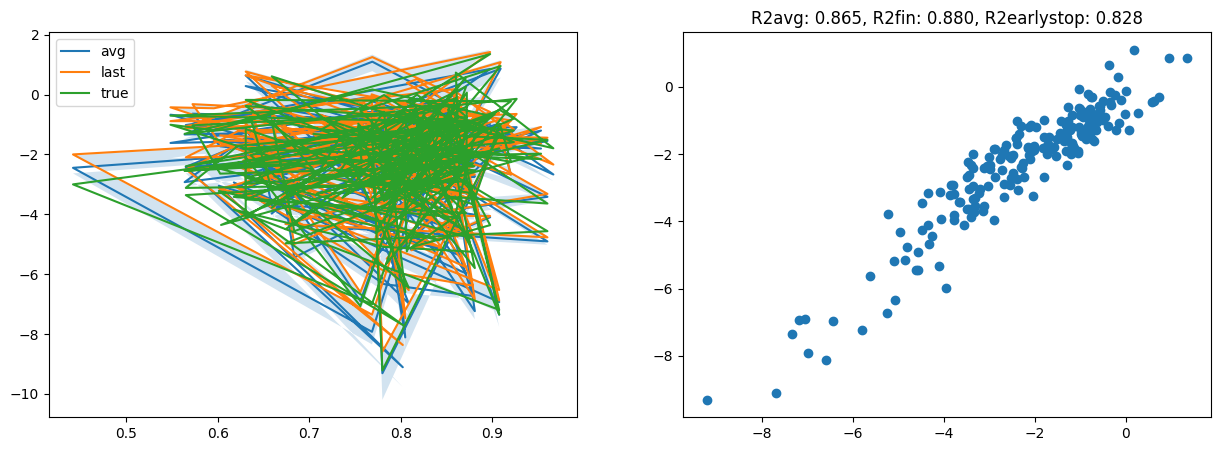

MSEavg 0.4222324
MSEfin 0.37688228


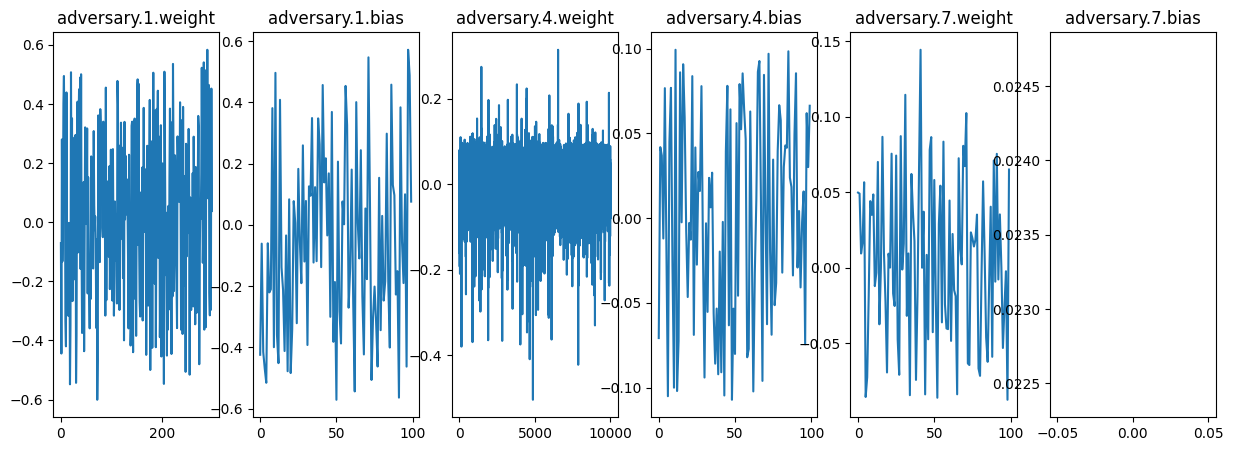

In [217]:
np.random.seed(20221212)
plot_results(agmm, S_test, X_test, Y_test, ind=0)

In [218]:
'''
0.15
now use x to predict g, using the method we used eailer
y
'''


'\n0.15\nnow use x to predict g, using the method we used eailer\ny\n'